(supervised:ann:cnn-learn)=
# What did the CNN learn?

We want to obtain some insight into the internal workings of CNNs. The techniques presented below are mainly used for CNNs, but same principles apply to all types of feedforward ANNs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

data_path = '/home/jef19jdw/myfiles/datasets_teaching/ds2/catsdogs/data/'

2023-07-03 06:38:04.012731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# workarounds for some problems with Tensorflow (only use if neccessary)

#import os

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

#os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/usr/lib/cuda'

In [3]:
model = keras.models.load_model('cnnmodel')
model.summary()

2023-07-03 06:38:05.643827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-03 06:38:05.643893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: WHZ-46349
2023-07-03 06:38:05.643911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: WHZ-46349
2023-07-03 06:38:05.644122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-07-03 06:38:05.644175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-07-03 06:38:05.644191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-07-03 06:38:05.645067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Networ

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 126, 126, 16)      448       
                                                                 
 conv2 (Conv2D)              (None, 124, 124, 16)      2320      
                                                                 
 pool1 (MaxPooling2D)        (None, 62, 62, 16)        0         
                                                                 
 conv3 (Conv2D)              (None, 60, 60, 32)        4640      
                                                                 
 conv4 (Conv2D)              (None, 58, 58, 32)        9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 29, 29, 32)        0

## Visualizing Feature Maps

Each convolutional layer outputs a stack of feature maps. In the language of CNNs feature maps are filtered versions of the input image. In the language of ANNs a feature map contains neuron activations. Given an input image we may look at the feature maps to get an idea of what features the learned filters extract.

To get activations of intermediate layers for a given input image we define a new Keras model, which reuses parts of the existing model. When creating a model Keras builds a TensorFlow data structure (the *graph*) representing the flow of data and operations on data. This graph starts with an input node (a [`Tensor`](https://www.tensorflow.org/api_docs/python/tf/Tensor) object) and ends with the output node (again a `Tensor` object). When calling `Model.predict` Keras takes the data and hands it over to TensorFlow. TensorFlow executes the graph with the provided data and returns the output to Keras. Each layer's output is represented by an intermediate `Tensor` object in the graph, too.  So we may fool Keras by creating a new model providing existing `Tensor` objects as inputs and outputs of the model. This feature is not well documented. What is missing in the documentation is the fact, that keyword arguments `inputs` and `outputs` of the `Model` constructor also accept TensorFlows `Tensor` objects instead of Keras' `Input` and `Layer` objects. `Tensor` objects of existing models or layers are accessible through `inputs` and `outputs` member variables. From this knowledge we are able to create a new `Model` instance using an existing TensorFlow graph or parts of it.

In [4]:
layer_name = 'conv1'

submodel = keras.models.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)
submodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 126, 126, 16)      448       
                                                                 
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


No we load an image and get corresponding predictions from the submodel. Predictions of the submodel are the feature maps (after applying activation function) of the chosen layer in the original model. The image has to be resized to fit the model's input size. We use Kera's [`load_img`](https://keras.io/api/preprocessing/image/#loadimg-function). This function returns a [`PIL image object`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image) which is understood by NumPy.

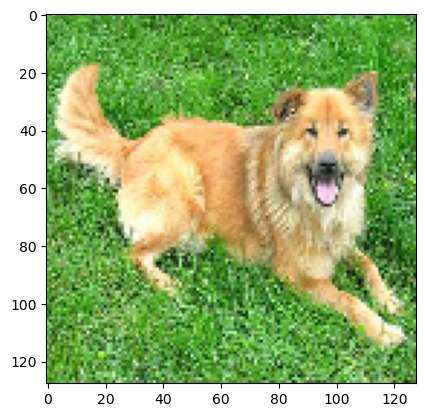

1/1 [==============================] - 0s 203ms/step
(126, 126, 16)


In [5]:
img_size = 128
img = keras.preprocessing.image.load_img(data_path + 'unlabeled/4.jpg',
                                         target_size=(img_size, img_size))
img = np.asarray(img, dtype=np.float32)

fig, ax = plt.subplots()
ax.imshow(img / 255)
plt.show()

fmaps = submodel.predict(img.reshape(1, img_size, img_size, 3))
fmaps = fmaps.reshape(fmaps.shape[1:])
print(fmaps.shape)

It remains to rescale and plot all the feature maps. We first rescale all feature maps at once to have range $[0,1]$. Then we rescale each map individually to increase contrast for low intensity images. The individual scaling factor will be shown in the plots. A high factor indicates low intensities.

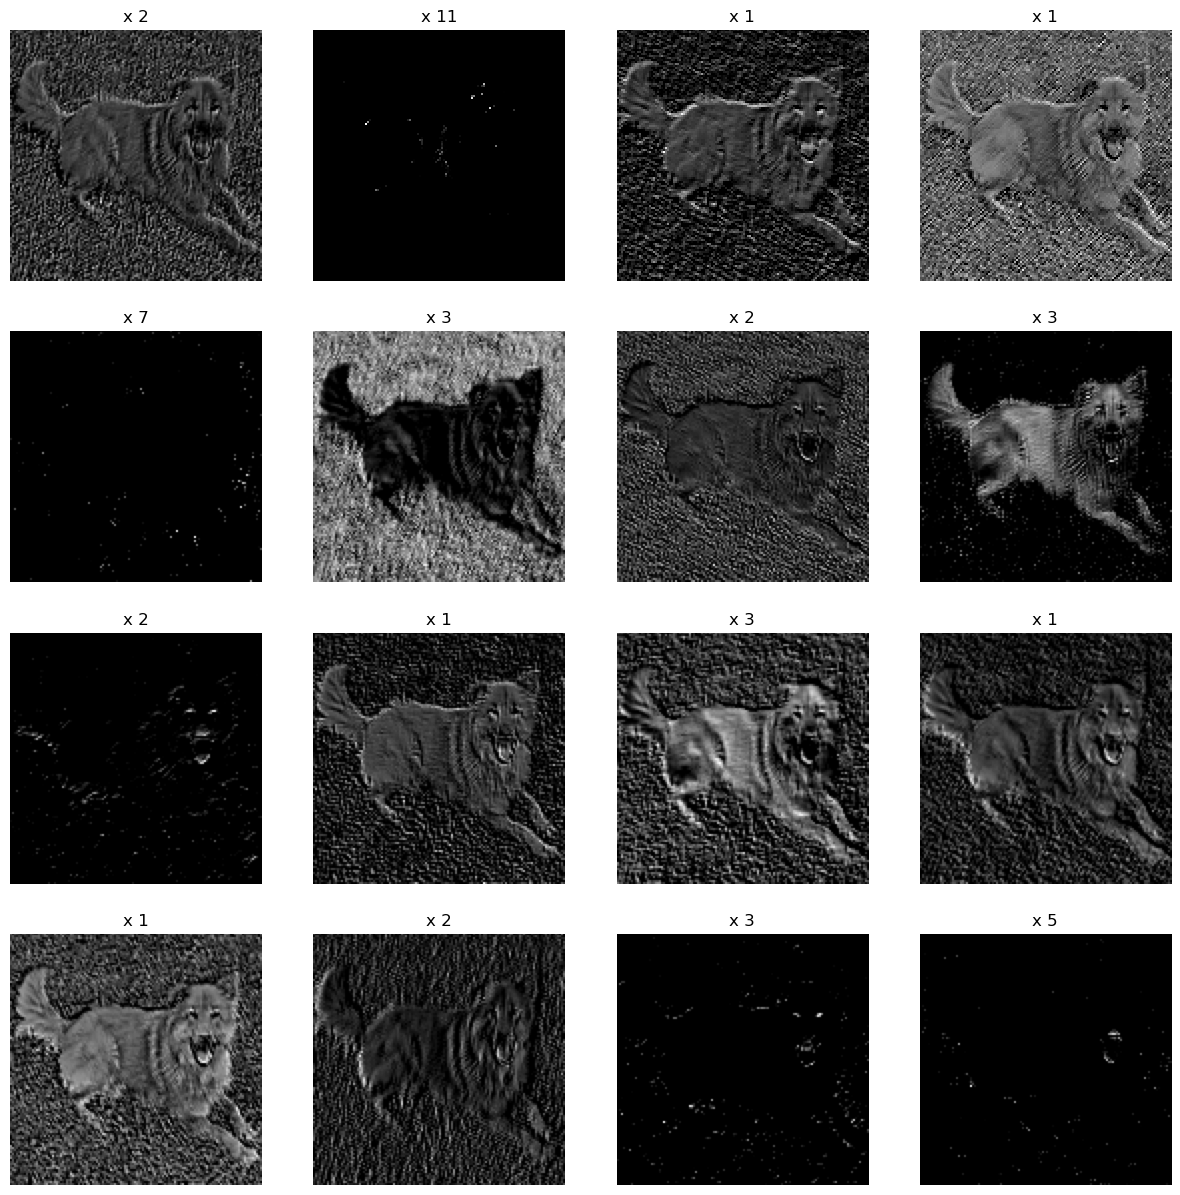

In [6]:
cols = 4
rows = fmaps.shape[2] // cols

fmaps = 1 / (fmaps.max() - fmaps.min()) * (fmaps - fmaps.min())

fig, axs = plt.subplots(rows, cols, figsize=(15, 15))

for r in range(0, rows):
    for c in range(0, cols):
        fmap = fmaps[:, :, r * cols + c]
        if fmap.max() > 0:
            fac = 1 / fmap.max()
            fmap = fac * fmap
        else:
            fac = 1
        axs[r, c].imshow(fmap, cmap='gray')
        axs[r, c].axis('off')
        axs[r, c].set_title('x {:.0f}'.format(fac))
        
plt.show()

## Visualizing Filters

Each convolutional layer is defined by a list of filters. Filters are a set of shared weights. We may obtain weights of a layer by calling [`Layer.get_weights`](https://keras.io/api/layers/base_layer/#getweights-method). For layers with input from a bias neuron the method returns a list with two items. First item is a NumPy array of regular weights, second is a NumPy array of bias weights.

In [7]:
layer = model.get_layer('conv1')

filters, bias_weights = layer.get_weights()
print(filters.shape, bias_weights.shape)

(3, 3, 3, 16) (16,)


In the first layer we have three input channels (red, green, blue). Thus, filter depth is 3 and we may visualize each filter as color image. Filter pixels may have range different from [0, 1]. Thus, we linearly scale all filters.

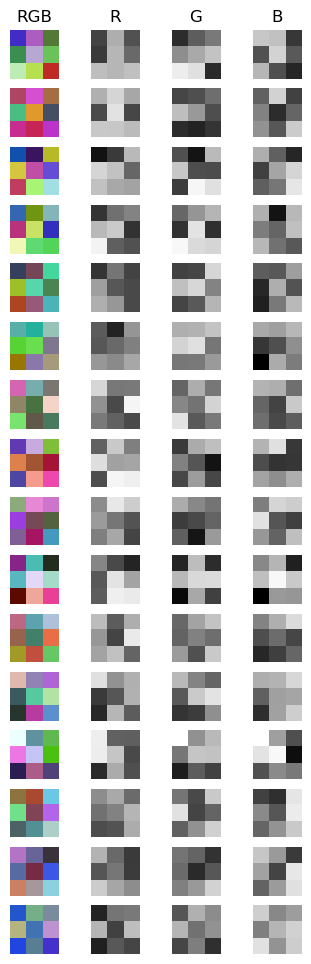

In [8]:
filters = 1 / (filters.max() - filters.min()) * (filters - filters.min())

fig, axs = plt.subplots(filters.shape[3], 4, figsize=(4, 12))

for row in range(0, filters.shape[3]):
    axs[row, 0].imshow(filters[:, :, :, row], vmin=0, vmax=1)
    axs[row, 0].axis('off')
    axs[row, 1].imshow(filters[:, :, 0, row], cmap='gray', vmin=0, vmax=1)
    axs[row, 1].axis('off')
    axs[row, 2].imshow(filters[:, :, 1, row], cmap='gray', vmin=0, vmax=1)
    axs[row, 2].axis('off')
    axs[row, 3].imshow(filters[:, :, 2, row], cmap='gray', vmin=0, vmax=1)
    axs[row, 3].axis('off')
    if row == 0:
        axs[row, 0].set_title('RGB')
        axs[row, 1].set_title('R')
        axs[row, 2].set_title('G')
        axs[row, 3].set_title('B')
        
plt.show()

For deeper layers there is no color interpretation, because filters have more than 3 depth levels. So we may visualize a filter as a list of sections perpendicular to the depth axis. In the following plot each row contains the sections of one filter.

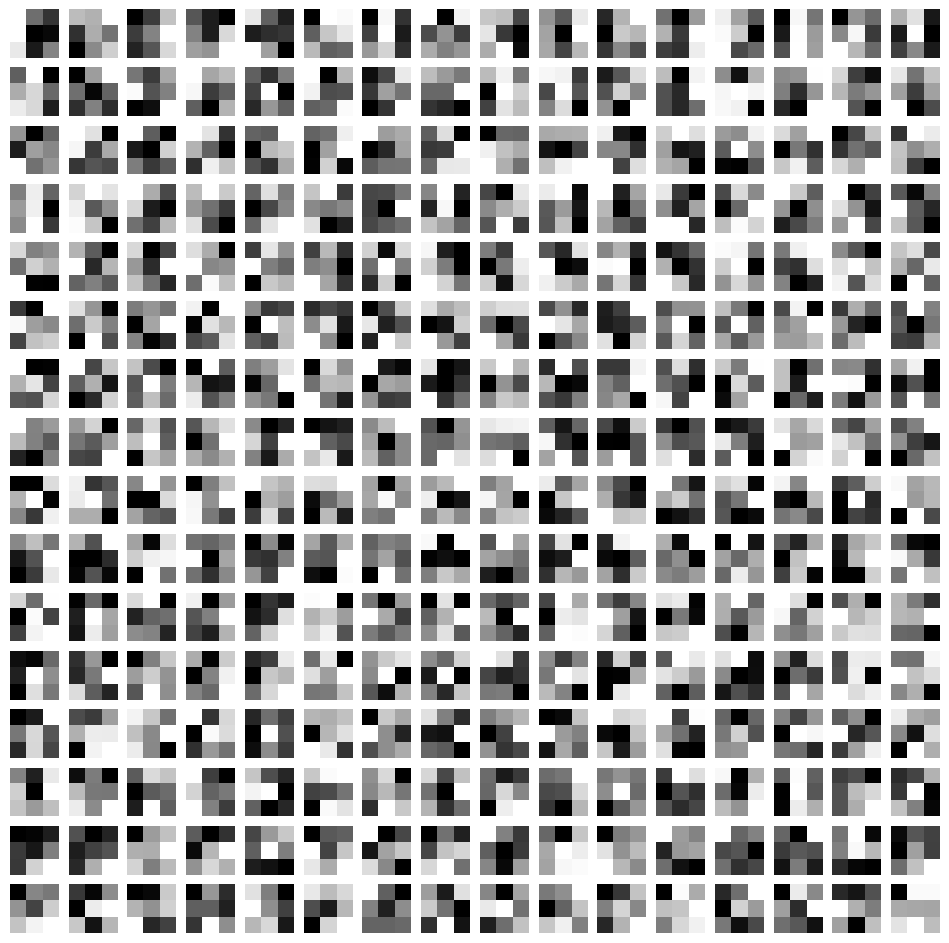

In [9]:
layer = model.get_layer('conv2')

filters, bias_weights = layer.get_weights()
filters = 1 / (filters.max() - filters.min()) * (filters - filters.min())

fig, axs = plt.subplots(filters.shape[3], filters.shape[2], figsize=(12, 12))

for row in range(0, filters.shape[3]):
    for col in range(0, filters.shape[2]):
        axs[row, col].imshow(filters[:, :, col, row], cmap='gray')
        axs[row, col].axis('off')
        
plt.show()

## Maximizing Neuron Activation

To get a better idea of what causes neurons to fire, we may seek for images with high activation of a fixed neuron. This is an optimization problem. The objective is a neuron's activation. The search space is the set of all images fitting the model's input size.

We apply gradient descent to the negative objective (that is, gradient ascent to the objective) and use some Keras features simplifying implementation.

The objective is a neuron's output and we handle the objective as a Keras model. This will allow for using Keras to compute gradients.

In [41]:
layer = model.get_layer('conv3')
neuron = (5, 5, 0)
#layer = model.get_layer('dense2')
#neuron = (0, )
#layer = model.get_layer('out')
#neuron = (0, )

submodel = keras.models.Model(inputs=model.inputs, outputs=layer.output[(0, ) + neuron])
submodel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 126, 126, 16)      448       
                                                                 
 conv2 (Conv2D)              (None, 124, 124, 16)      2320      
                                                                 
 pool1 (MaxPooling2D)        (None, 62, 62, 16)        0         
                                                                 
 conv3 (Conv2D)              (None, 60, 60, 32)        4640      
                                                                 
 tf.__operators__.getitem_4   ()                       0   

Now we define a function which computes objective value and gradient for a given input image. First we call [`convert_to_tensor`](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor) to convert the image into a `Tensor` object, which fits the model's input dimensions. Then we tell TensorFlow to watch the operations performed on the image while calculating the objective function. From the collected information TensorFlow then can calculate the gradient of the objective function. To watch the flow of the image through the TensorFlow graph we have to create a context manager of type [`GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape). The flow of all variables marked for watching with [`GradientTape.watch`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#watch) is recorded for all graph executions inside the `with` block. After executing the graph we get the gradient from [`GradientTape.gradient`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient). Note that calling `Model.predict` does not support watching the variables flow. Instead we have to use a different API variant of Keras: `Model` objects are callable, that is, they can be used as a function, and yield a prediction if called with some input as argument.

In [42]:
def get_grad(submodel, img):
    
    img_tensor = tf.convert_to_tensor(img.reshape(1, img_size, img_size, 3))

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        objective_value = submodel(img_tensor)
        grad = tape.gradient(objective_value, img_tensor)

    return objective_value.numpy(), grad.numpy().reshape(img.shape)

We are ready for gradient ascent. We are free to choose an arbitrary initial guess, but we have to keep in mind that on the one hand we may end up in a local maximum and on the other hand there might be many global maxima. Thus, the initial guess will have influence on the result. We put everything in a function. So we can reuse it below.

In [43]:
def gradient_ascent(submodel, init_img, max_iter, step_length):

    img = init_img

    for i in range(0, max_iter):
        obj, grad = get_grad(submodel, img)
                    
        img = img + step_length * grad
        
        print(i, obj, np.max(np.abs(grad)))
        
    return img

In [44]:
# constant image
img = 128 * np.ones((img_size, img_size, 3), dtype=float)

# photo
#img = keras.preprocessing.image.load_img(data_path + 'unlabeled/365.jpg',
#                                         target_size=(img_size, img_size))
#img = np.asarray(img, dtype=np.float32)

0 0.07344329 0.0003321536350995302
1 0.073513456 0.00028220663079991937
2 0.07358889 0.0003213614400010556
3 0.07369768 0.00030644104117527604
4 0.07383166 0.00031520603806711733
5 0.07399155 0.00030644104117527604
6 0.074129954 0.00031513432622887194
7 0.0742565 0.00030454201623797417
8 0.07441732 0.0003239291545469314
9 0.07457861 0.00030454201623797417
10 0.07470061 0.00030454201623797417
11 0.07487879 0.00030454201623797417
12 0.07501966 0.00030454201623797417
13 0.07516515 0.0003058453439734876
14 0.075305745 0.00030454201623797417
15 0.0754803 0.0003058453439734876
16 0.07562959 0.00030454201623797417
17 0.07579061 0.00030454201623797417
18 0.07593748 0.0003058453439734876
19 0.07606852 0.00030454201623797417
20 0.076212205 0.00030454201623797417
21 0.07638178 0.0003369719488546252
22 0.076535545 0.00030454201623797417
23 0.07666714 0.0003113079583272338
24 0.07682478 0.00030454201623797417
25 0.07697314 0.00030454201623797417
26 0.07714298 0.00030454201623797417
27 0.077249855 0

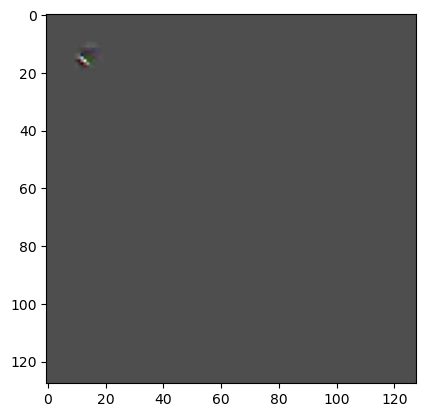

In [45]:
# parameters for gradient ascent
img = gradient_ascent(submodel, img, 1000, 100) # for conv3/dense2 with constant
#img = gradient_ascent(submodel, img, 100, 100) # for output neuron with photo

# show result
img_to_show = 1 / (img.max() - img.min()) * (img - img.min())
fig, ax = plt.subplots()
ax.imshow(img_to_show)
plt.show()

If we maximize the output of a neuron in a convolutional layer, then the result will differ from the initial guess only in the region the neuron is connected to. All other pixels have no influence on the neuron's output. Thus, corresponding components of the gradient are zero in each iteration. To see the details we crop the image. For neurons in the first convolution layer, the maximizing input is the corresponding filter.

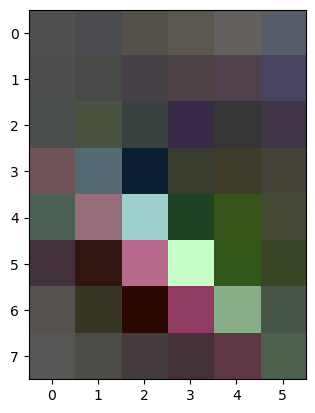

In [46]:
# mask pixels to keep when cropping
mask_r = np.abs(img_to_show[:, :, 0] - img_to_show[-1, -1, 0]) > 0.09
mask_g = np.abs(img_to_show[:, :, 1] - img_to_show[-1, -1, 1]) > 0.09
mask_b = np.abs(img_to_show[:, :, 2] - img_to_show[-1, -1, 2]) > 0.09
mask = np.logical_or(mask_r, np.logical_or(mask_g, mask_b))

# get active columns    
col_mask = mask.any(0)
bb_col_start = col_mask.argmax()
bb_col_end = img_to_show.shape[1] - 1 - col_mask[::-1].argmax()

# get active rows
row_mask = mask.any(1)
bb_row_start = row_mask.argmax()
bb_row_end = img_to_show.shape[0] - 1 - row_mask[::-1].argmax()
    
# crop image to bounding box
bb_img = img_to_show[bb_row_start:(bb_row_end + 1), bb_col_start:(bb_col_end + 1)]

# show cropped image
fig, ax = plt.subplots()
ax.imshow(bb_img, cmap='gray')
plt.show()

Maximizing the output of the first output neuron modifies the initial guess to yield output 1 (the maximum value of sigmoid activation function). That is, we obtain an image the net regards as a cat. Starting with a plain image we get some artistic images. Starting with a photo of a dog we get a slightly blurred dog, which the net labels as cat. By modifying images that way CNNs can be fooled. The CNN 'sees' a very different thing than a human.

In [47]:
pred = model.predict(img.reshape(1, *img.shape))[0]
print('cat: {:.4f}, dog: {:.4f}'.format(pred[0], pred[1]))

1/1 [==============================] - 0s 24ms/step
cat: 0.9065, dog: 0.2174


The idea of searching for output maximizing inputs is known as *dreaming*. Google's [DeepDream](https://en.wikipedia.org/wiki/DeepDream) from 2015 uses the techniques discussed above. A similar application of dreaming CNNs is [neural style transfer](https://en.wikipedia.org/wiki/Neural_Style_Transfer), also appearing in 2015.

## Maximizing Feature Maps

Instead of maximizing single neuron outputs we could look for feature maps having high values in all components or at least high mean (the latter is easier to differentiate). An input image that maximizes a feature map would show a pattern that is tightly connected to the corresponding filter.

0 0.010571016 2.397079242655309e-06
1 0.012987887 2.784569460345665e-06
2 0.01555704 2.6928230454359436e-06
3 0.018290414 2.2864280708745355e-06
4 0.021174435 2.192614147134009e-06
5 0.024220329 2.4407656837865943e-06
6 0.027513845 2.4178386865969514e-06
7 0.03095166 2.223908268206287e-06
8 0.03454724 2.0893653527309652e-06
9 0.038174365 2.028772314588423e-06
10 0.041862242 2.097629021591274e-06
11 0.045696992 2.3129020974010928e-06
12 0.049698126 2.385100970059284e-06
13 0.05387558 2.3095196866051992e-06
14 0.058383714 2.396672925897292e-06
15 0.063163 2.3852505819377257e-06
16 0.068157524 2.510322474336135e-06
17 0.07321679 2.4331638996955007e-06
18 0.07840866 2.3761479042150313e-06
19 0.08379156 2.492263092790381e-06
20 0.089350894 2.4447754185530357e-06
21 0.09505746 2.397075149929151e-06
22 0.10108615 2.545427378208842e-06
23 0.10727019 2.3443969894287875e-06
24 0.11355108 2.2837014057586202e-06
25 0.11987263 2.431382426948403e-06
26 0.12621516 2.6055895432364196e-06
27 0.13275892

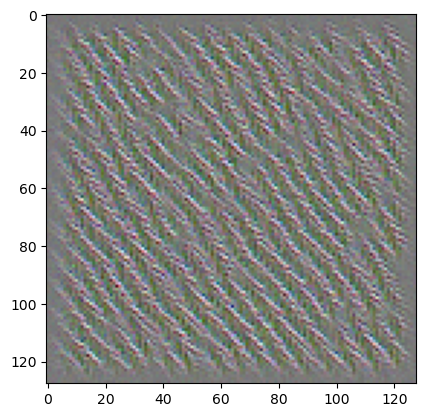

In [48]:
layer = model.get_layer('conv4')
fmap_index = 2

submodel = keras.models.Model(inputs=model.inputs,
                              outputs=tf.math.reduce_mean(layer.output[0, :, :, fmap_index]))


img = 255 * np.random.default_rng(0).normal(0.5, 0.2, size=(img_size, img_size, 3))

# parameters for gradient ascent
img = gradient_ascent(submodel, img, 1000, 1000000)

# show result
img_to_show = 1 / (img.max() - img.min()) * (img - img.min())
fig, ax = plt.subplots()
ax.imshow(img_to_show)
plt.show()

## Class Activation Maps

We may ask what regions of an image make the CNN 'think' that there is a cat or a dog. A simple approach is to pass an image through the CNN and then look at the gradient of the last convolution layer's output with respect to an output neuron (cat or dog). By the principle of local connectivity spatial regions of a feature map are strongly related to the same spatial regions of the input image. High positive components in the gradient tell us that increasing the presence of the corresponding feature in the corresponding region would increase the chosen output neuron's output. Very negative components tell us that the feature in this region lowers output.

To get the gradient of an output neuron with respect to the outputs of a hidden layer we have to remember what TensorFlow's automatic differentiation routines can do and what they cannot do. What TensorFlow can do is calculating the gradient of some function with respect to a concrete tensor flowing through the graph. But derivatives with respect to some abstract tensor (a kind of placeholder) are not accessible. So we may formulate more precisely: we want to have the gradient of a neuron's output with respect to the tensor flowing out of a hidden layer when some tensor is pushed through the CNN. The problem is that Keras does not implement accessing interim results. The solution is to create a new model with two outpus. One output is the usual output layer, the other is the hidden convolution layer of interest. This does not change the CNN's structure, but forces Keras to provide access to the concrete tensor object coming out of the hidden layer and moving on to the next layer.

In [49]:
layer = model.get_layer('conv4')

submodel = keras.models.Model(inputs=model.inputs,
                              outputs=[layer.output, model.output])

Now we load an image and preprocess it as usual.

In [75]:
img = keras.preprocessing.image.load_img(data_path + 'unlabeled/1696.jpg', # 318, 786, 907, 1696
                                         target_size=(img_size, img_size))
img = np.asarray(img, dtype=np.float32)

We want to have two gradients: the gradient of the cat output neuron and the gradient of the dog output neuron. Since we have two outputs in our model, predictions yield a list of two tensors.

In [76]:
img_tensor = tf.convert_to_tensor(img.reshape(1, img_size, img_size, 3))

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    pred = submodel(img_tensor)
    cat_grad = tape.gradient(pred[1][0, 0], pred[0])

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    pred = submodel(img_tensor)
    dog_grad = tape.gradient(pred[1][0, 1], pred[0])

fmaps = pred[0].numpy()[0, :, :, :]
cat_grad = cat_grad.numpy()[0, :, :, :]
dog_grad = dog_grad.numpy()[0, :, :, :]

print(fmaps.shape, cat_grad.shape, dog_grad.shape)

(58, 58, 32) (58, 58, 32) (58, 58, 32)


Now we are ready to compute the class activation map (CAM). The CAM has same shape as a feature map in the last convolutional layer (same width and height, depth is 1). The CAM is a weighted sum of all feature maps of the last convolutional layer. The weights are calculated from the gradient by spacial averaging. Thus, for each feature map the weight is something like a mean partial derivative. If the weight is positive, then the feature represented by the corresponding feature map potentially increases class activation. If the weight is negative, then class activation is decreased the more nonzero values in the feature map.

Multiplying mean gradients by the feature map values yields high positive numbers in regions where a class activation increasing feature is present in the input image, but negative values in regions where features are present which potentially decrease class activation.

We scale the CAM to $[0,1]$ such that $0.5$ corresponds to 0 in the original CAM.

cat: 0.12, dog: 1.00


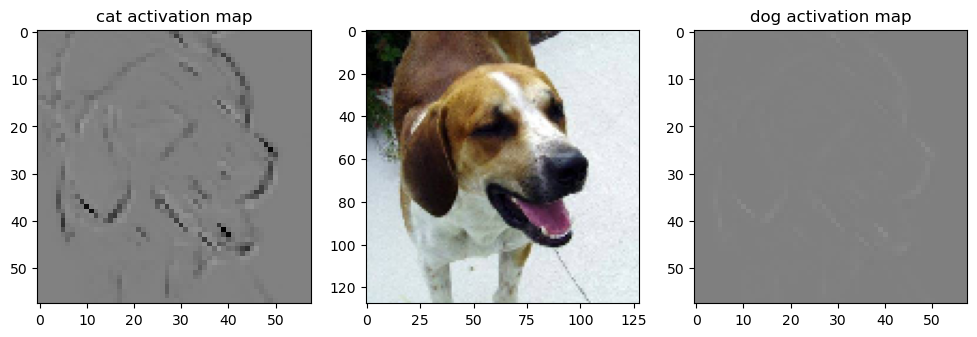

In [77]:
cat_weights = np.mean(cat_grad, axis=(0, 1)).reshape(1, 1, -1)
cat_cam = np.sum(fmaps * cat_weights, axis=2)
dog_weights = np.mean(dog_grad, axis=(0, 1)).reshape(1, 1, -1)
dog_cam = np.sum(fmaps * dog_weights, axis=2)

fac = np.maximum(np.max(np.abs(cat_cam)), np.max(np.abs(dog_cam)))
cat_cam = 0.5 * (1 + cat_cam / fac)
dog_cam = 0.5 * (1 + dog_cam / fac)

print('cat: {:.2f}, dog: {:.2f}'.format(pred[1][0, 0], pred[1][0, 1]))

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 6))
ax1.imshow(cat_cam, cmap='gray', vmin=0, vmax=1)
ax2.imshow(img / 255)
ax3.imshow(dog_cam, cmap='gray', vmin=0, vmax=1)
ax1.set_title('cat activation map')
ax3.set_title('dog activation map')
plt.show()

For better visual interpretation we overlay the original image with the CAM. Many people do this in a very sloppy way by simply resizing the CAM to image size. But we take the hard and correct one. The difficult part is to find the region associated with a value in the CAM. Going backwards through the CNN's layers we have to calculate size and position of the *region of interest* (ROI) for each component of the CAM.

A pixel in the feature map results from a convolution with a 3x3 filter. Thus a 3x3 region is the preimage of the pixel. One layer up we have a 5x5 region (convolution with 3x3 filter again). Then there is a pooling layer. So the ROI's size before pooling is 10x10. Then again two 3x3 convolutions, yielding a 14x14 ROI.

The CAM is 58x58. The original image is 128x128. Centers of all ROIs have to be placed equally spaced in the 128x128 image such that there is a 7 pixel boundary. Else some ROIs would partially lie outside the image. Distance between ROI centers is $(128-14)/57=2$ pixels.

With this knowledge we create a stack of images. One image per CAM component. Each containing the CAM component's value in all pixels belonging to the component's ROI. Then we merge all images in the stack by taking the pixelwise mean. Here we have to take into account that pixels near the boundary belong to fewer ROIs than pixels in the image center.

To overlay CAM image and original image we use a color map with blue for negative CAM values, gray for zero and red for positive CAM values.

In [80]:
def cam_to_img(cam):

    cam_size = cam.shape[0]
    roi_size = 14
    roi_gap = 2
    roi = np.zeros((img_size, img_size, cam_size * cam_size))
    mask = np.full(roi.shape, 0)
    for i in range(0, cam_size):
        for j in range(0, cam_size):
            first_i = roi_gap * i
            last_i = first_i + roi_size
            first_j = roi_gap * j
            last_j = first_j + roi_size
            roi[first_i:last_i, first_j:last_j, i * cam_size + j] = cam[i, j]
            mask[first_i:last_i, first_j:last_j, i * cam_size + j] = 1
        
    return roi.sum(axis=2) / mask.sum(axis=2)

def mix_images(gray, color):

    result = np.empty((img_size, img_size, 3))
    result[:, :, 0] = 0.1 * color.mean(axis=2)
    result[:, :, 1] = result[:, :, 0]
    result[:, :, 2] = result[:, :, 0]
    result[:, :, 0] = result[:, :, 0] + 0.89 * gray
    result[:, :, 1] = result[:, :, 1] + 0.89 * (0.5 - np.abs(gray - 0.5))
    result[:, :, 2] = result[:, :, 2] + 0.89 * (1 - gray)
    
    return result

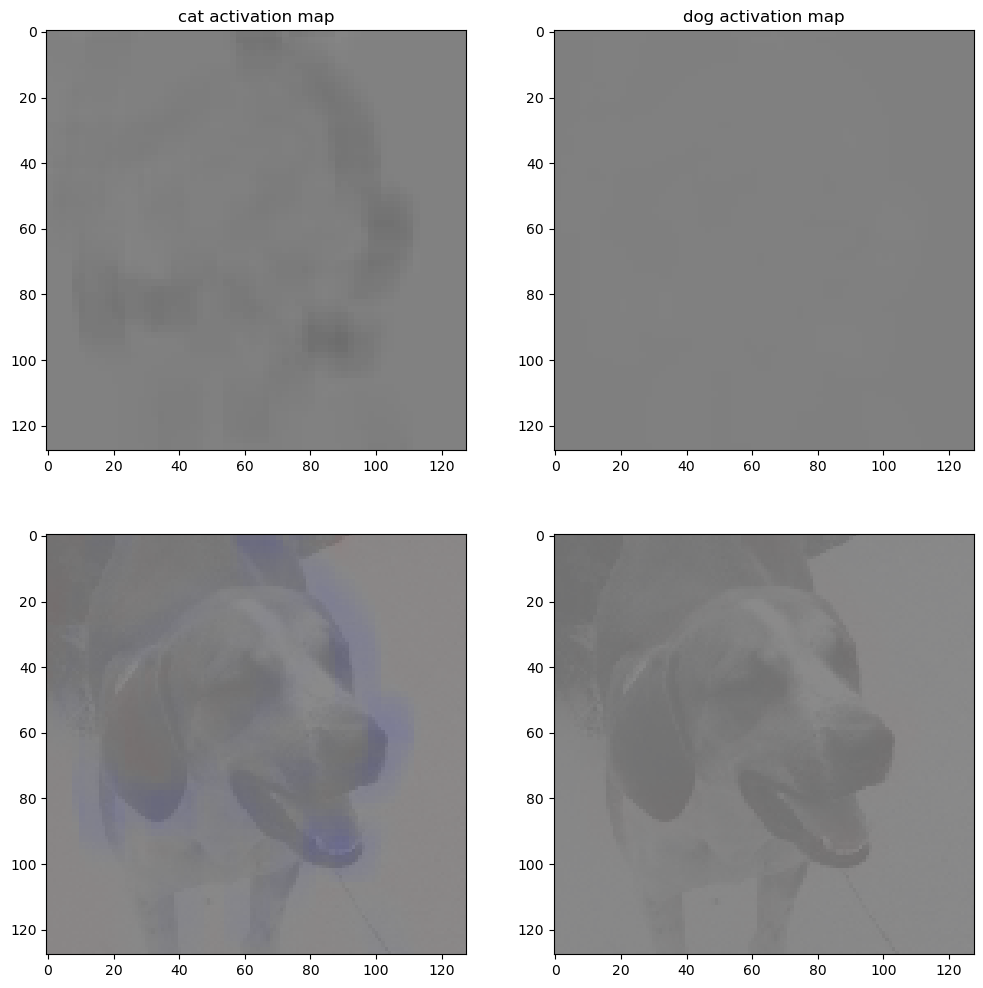

In [81]:
cat_img = cam_to_img(cat_cam)
dog_img = cam_to_img(dog_cam)

cat_mix = mix_images(cat_img, img / 255)
dog_mix = mix_images(dog_img, img / 255)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12, 12))
ax1.imshow(cat_img, cmap='gray', vmin=0, vmax=1)
ax2.imshow(dog_img, cmap='gray', vmin=0, vmax=1)
ax3.imshow(cat_mix)
ax4.imshow(dog_mix)
ax1.set_title('cat activation map')
ax2.set_title('dog activation map')
plt.show()